In [5]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "rice_leaf_disease", "lentils"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "mening_malumotlarim", data_nomi = "lentils")
# data_yuklab_olish(saqlash_uchun_papka = "mening_malumotlarim", data_nomi = "rice_leaf_disease")

Dataset yuklab olingan. mening_malumotlarim/lentils papkasini ni tekshiring.


In [5]:
import os 
from torch.utils.data import Dataset, DataLoader, random_split 
from torchvision import transforms as T 
from glob import glob 
from PIL import Image

class LentisDataset(Dataset):

    def __init__(self, data_yulagi, transformations=None): 
        self.rasm_yulaklari = glob(f"{data_yulagi}/*/*.png")
        self.transformations = transformations 
        print(len(self.rasm_yulaklari))
        
        self.klass_ismi = {}
        klass_qiymati = 0
        
        for i, yul in enumerate(self.rasm_yulaklari):
            
            klass_ismi = self.klassni_olib_kelish (yul)
            if not klass_ismi in self.klass_ismi: self.klass_ismi[klass_ismi] = klass_qiymati; klass_qiymati +=1

    def __len__(self): 
        return len(self.rasm_yulaklari)

    def klassni_olib_kelish(self, yulak): 
        return os.path.basename(yulak).split("_")[-2]

    def __getitem__(self, idx): 
        rasm = Image.open(self.rasm_yulaklari[idx])
                                                                      
        if self.transformations: rasm = self.transformations(rasm)
           

        javob = self.klass_ismi[self.klassni_olib_kelish(self.rasm_yulaklari[idx])]
        
        return rasm, javob  
    
        

tfs = T.Compose([T.Resize((224,224)), T.ToTensor() , T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                                                                      
ds = LentisDataset(data_yulagi="mening_malumotlarim/lentils", transformations=tfs)
ts_ds  = LentisDataset(data_yulagi="mening_malumotlarim/lentils", transformations=tfs)
print(len(ds))
print(ds.klass_ismi)
klass_ismi = ds.klass_ismi

classlar = klass_ismi.keys() 
klass_ism = list(classlar)

print (klass_ism)



297
297
297
{'skinned': 0, 'split': 1, 'whole': 2}
['skinned', 'split', 'whole']


In [6]:
sample_rasm, sample_javob = ds[0]
print("Type of rasm:", type(sample_rasm))
print("Type of javob:", type(sample_javob))

Type of rasm: <class 'torch.Tensor'>
Type of javob: <class 'int'>


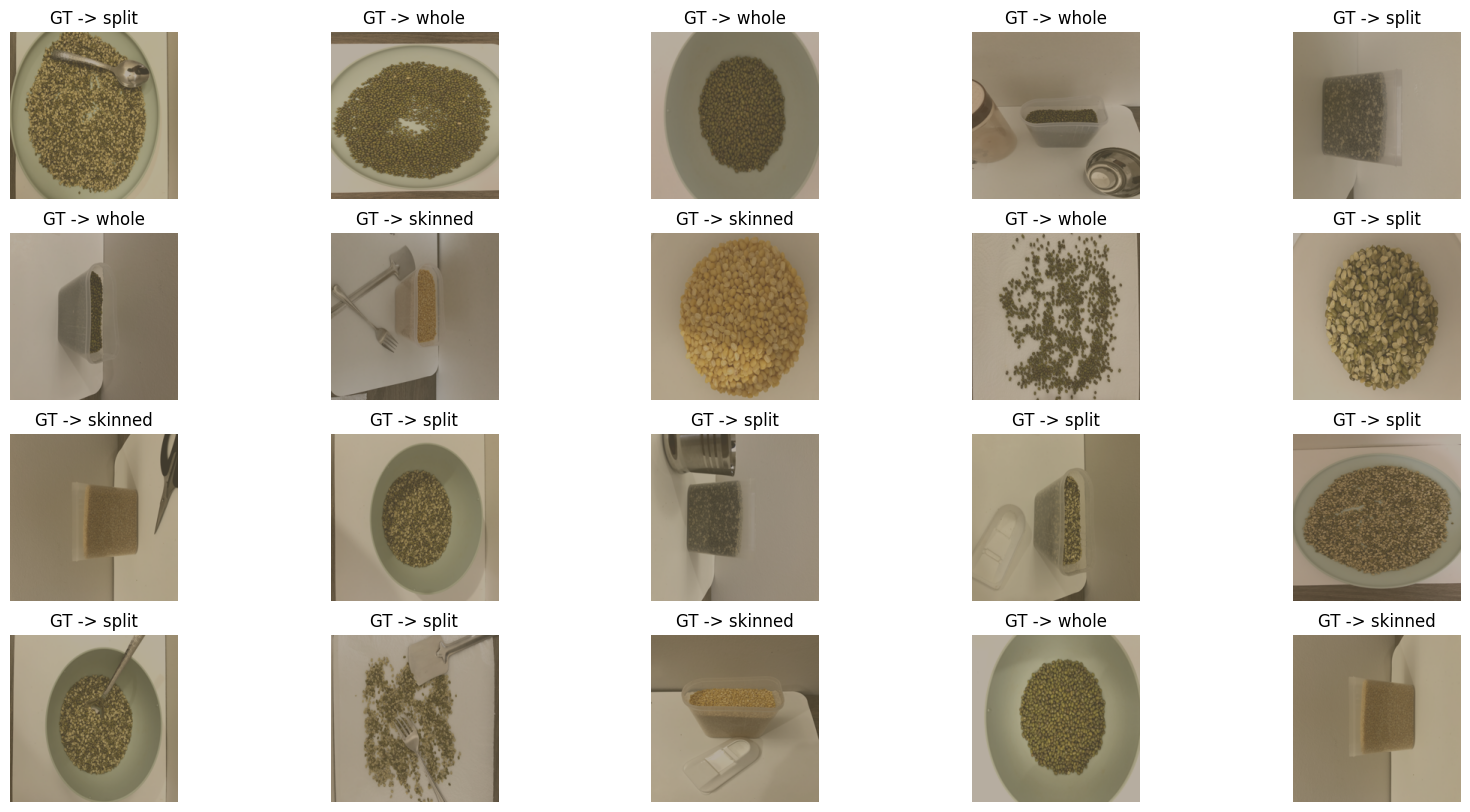

In [7]:
from utils import visualize
visualize(data = ds, rasmlar_soni = 20, qatorlar = 4, cmap = 'rgb', klass_nomlari = klass_ism)

In [5]:
split = [0.8 , 0.1, 0.1]
all_len = len(ds)
tr_len = int(all_len *split[0])
val_len = int(all_len * split[1])
ts_len = all_len-tr_len-val_len
print(len(ds))
print(tr_len)
print(val_len)
print(ts_len)

297
237
29
31


In [6]:
tr_ds, val_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, val_len, ts_len])
print(len(tr_ds))
print(len(val_ds))
print(len(ts_ds))
                                 

237
29
31


In [7]:
bs = 64 

tr_dl = DataLoader(dataset = tr_ds , batch_size = bs , shuffle = True , num_workers = 0)
val_dl = DataLoader(dataset = val_ds , batch_size = bs , shuffle = False , num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds , batch_size = bs , shuffle = False , num_workers = 0)


print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
                

4
1
1


In [8]:
import timm
model = timm.create_model(model_name = "resnet18", pretrained = True , num_classes = len(klass_ismi))
model                           

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [9]:
import torch
from torch import nn


class Model(nn.Module):



    def __init__(self, in_chs, out_chs,in_fs, ks,s, p, n_cls) :
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_chs, out_channels = out_chs, kernel_size=ks, stride= s, padding = p)
        self.conv_2 = nn.Conv2d(in_channels=out_chs, out_channels = out_chs*2, kernel_size=ks, stride= s, padding = p)
        self.conv_3 = nn.Conv2d(in_channels=out_chs*2, out_channels = out_chs*4, kernel_size=ks, stride= s, padding = p)

        self.linear_1 = nn.Linear(in_features=in_fs, out_features= in_fs // 2)
        self.linear_2 = nn.Linear(in_features=in_fs //2 , out_features= n_cls)
        self.act = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size =2, stride = 2)


    def forward(self, inp):

      out = self.conv_1(inp)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_2(out)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_3(out)
      out = self.act(out)
      out = self.mp(out)

      print(out.shape)

      bs= inp.shape[0]
      out = out.view(bs, -1)

      out= self.linear_1(out)
      out = self.act(out)
      out = self.linear_2(out)

      return out

rasm = torch.rand(1, 3, 224, 224)
model = Model(in_chs = 3, out_chs=8, in_fs= 25088 , ks=3 , s=1, p=1, n_cls=3)
model(rasm).shape

torch.Size([1, 32, 28, 28])


torch.Size([1, 3])

In [10]:
epochs = 5
device = "cpu"   #"cuda" if torch.cuda.is_available() else 
model.to(device)
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [11]:
from tqdm import tqdm
import os

best_acc = 0
prefix = "lentlist"

for epoch in range(epochs):
    model.train()
    print(f"{epoch + 1} - epoch jarayonlari boshlandi")

    epoch_loss, epoch_acc, total = 0, 0, 0

    for i, batch in tqdm(enumerate(tr_dl)):
        rasm, javob = batch
        print(type(javob))
        #labels = labels.to(device)
        rasm, javob = rasm.to(device), javob.to(device)
        total += rasm.shape[0]

        preds = model(rasm)
        loss = loss_fn(preds, javob)
        pred_cls = torch.argmax(preds.data, dim=1)
        epoch_acc += (pred_cls == javob).sum().item()
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch train jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi train loss     -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi train accuracy     -> {(epoch_acc / total):.3f}")

    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0

        for ids, batch in tqdm(enumerate(val_dl)):
            rasm, javob = batch
            rasm, javob = rasm.to(device), javob.to(device)
            val_total += rasm.shape[0]

            preds = model(rasm)
            loss = loss_fn(preds, javob)
            pred_cls = torch.argmax(preds.data, dim=1)

            val_epoch_acc += (pred_cls == javob).sum().item()
            val_epoch_loss += loss.item()

            val_acc = val_epoch_acc / val_total

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch validation jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi validation loss     -> {(val_epoch_loss / len(val_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi validation accuracy     -> {(val_acc):.3f}")

    if val_acc > best_acc:
        os.makedirs("modellar", exist_ok=True)
        best_acc = val_acc
        torch.save(model.state_dict(), f"modellar/{prefix}_best_model.pth")


1 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:11, 11.43s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:23, 11.66s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:35, 11.84s/it]

<class 'torch.Tensor'>
torch.Size([45, 32, 28, 28])


4it [00:46, 11.52s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch train jarayoni natijalari :
 1- epochdagi train loss     -> 3.889
 1- epochdagi train accuracy     -> 0.371


0it [00:00, ?it/s]

torch.Size([29, 32, 28, 28])


1it [00:00,  1.90it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch validation jarayoni natijalari :
 1- epochdagi validation loss     -> 1.702
 1- epochdagi validation accuracy     -> 0.414
2 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:09,  9.60s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:20, 10.65s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:33, 11.69s/it]

<class 'torch.Tensor'>
torch.Size([45, 32, 28, 28])


4it [00:45, 11.46s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch train jarayoni natijalari :
 2- epochdagi train loss     -> 1.375
 2- epochdagi train accuracy     -> 0.426


0it [00:00, ?it/s]

torch.Size([29, 32, 28, 28])


1it [00:00,  1.72it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch validation jarayoni natijalari :
 2- epochdagi validation loss     -> 1.260
 2- epochdagi validation accuracy     -> 0.310
3 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:08,  8.43s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:18,  9.20s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:28,  9.65s/it]

<class 'torch.Tensor'>
torch.Size([45, 32, 28, 28])


4it [00:39,  9.85s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch train jarayoni natijalari :
 3- epochdagi train loss     -> 1.125
 3- epochdagi train accuracy     -> 0.401


0it [00:00, ?it/s]

torch.Size([29, 32, 28, 28])


1it [00:00,  1.71it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch validation jarayoni natijalari :
 3- epochdagi validation loss     -> 1.131
 3- epochdagi validation accuracy     -> 0.276
4 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:10, 10.35s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:20, 10.36s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:30, 10.11s/it]

<class 'torch.Tensor'>
torch.Size([45, 32, 28, 28])


4it [00:41, 10.27s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch train jarayoni natijalari :
 4- epochdagi train loss     -> 0.996
 4- epochdagi train accuracy     -> 0.447


0it [00:00, ?it/s]

torch.Size([29, 32, 28, 28])


1it [00:00,  1.84it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch validation jarayoni natijalari :
 4- epochdagi validation loss     -> 0.947
 4- epochdagi validation accuracy     -> 0.690
5 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:12, 12.02s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:22, 11.37s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:33, 10.85s/it]

<class 'torch.Tensor'>
torch.Size([45, 32, 28, 28])


4it [00:43, 10.78s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch train jarayoni natijalari :
 5- epochdagi train loss     -> 0.885
 5- epochdagi train accuracy     -> 0.608


0it [00:00, ?it/s]

torch.Size([29, 32, 28, 28])


1it [00:00,  1.39it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch validation jarayoni natijalari :
 5- epochdagi validation loss     -> 0.854
 5- epochdagi validation accuracy     -> 0.655


In [41]:
rasm, javob = next(iter(ts_dl))


model.eval ()
preds = []
images = []
lbls = []

for rasm, javob in zip(rasm, javob):
  rasm, javob = rasm.to(device), javob.to(device)
  # print(rasm.unsqueeze(0).shape)
  pred = model(rasm.unsqueeze(0))
  print(pred.shape)
  pred_class = torch.argmax(pred, dim =1)
  images.append(rasm)
  lbls.append(javob)
  preds.append(pred_class)
print(len(preds))

torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1

In [2]:
import random 
from utils import tensor_2_im 

num_rasm , row = 25 , 5 


plt.figure(figsize = (20 , 10))
indekslar = [random.randint(0 , len(images ) - 1 ) for _ in range(num_rasm)]

for i , indeks in enumerate (indekslar ) : 
    rasm = images[indeks]
    javob = lbls[indeks]
    pred = preds[indeks]
    
    plt.subplot(row , num_rasm // row , i + 1) 
    plt.imshow(tensor_2_im(rasm , t_type = "gray"))
    plt.axis("off")
    plt.title(f"GT -> {javob} | Pred -> {pred}")

C:\Users\Muhammadziyo\anaconda3\envs\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'plt' is not defined

In [47]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("skinned_5.png")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


torch.Size([3, 224, 224])


torch.Size([1, 32, 28, 28])


'whole'

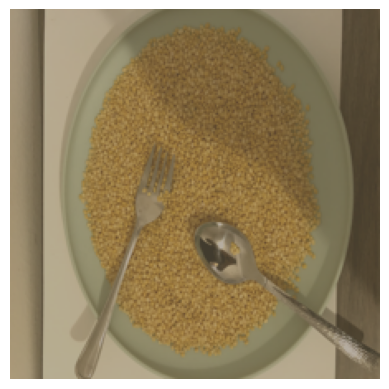

In [49]:
pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_nomlari[pred_class.item()])

torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


'whole'

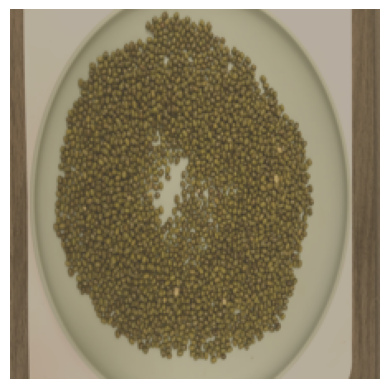

In [50]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("whole_93.png")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)

pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_nomlari[pred_class.item()])


torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


'whole'

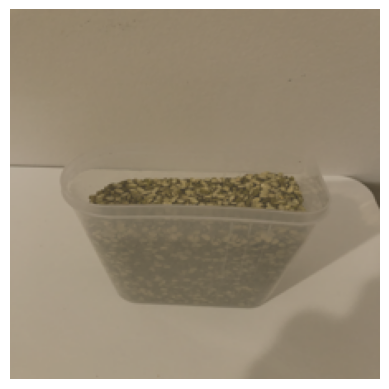

In [51]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("split_26.png")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)

pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_nomlari[pred_class.item()])